In [39]:
%matplotlib inline


Nistats: Functional MRI in Python
=========================================================

[Nistats](https://nistats.github.io/) is a Python module for fast and easy functional MRI statistical analysis.

It leverages [Nilearn](), [Nibabel]() and other Python libraries from the Python scientific stack like [Scipy](), [Numpy]() and [Pandas]().

In this tutorial, we're going to explore `nistats` functionality by analyzing a single subject single run example using a General Linear Model (GLM). We're gonna use the same example dataset (ds000114) as from the `nibabel`
and `nilearn` tutorials. As this is a multi run multi task dataset, we've to decide on a run and a task we want to analyze. Let's go with `ses-test` and `task-fingerfootlips` of `sub-01`.






Setting and inspecting the data
=========================

At first, we have to set and indicate the data we want to analyze. As stated above, we're going to use the anatomical image and the preprocessed functional image of `sub-01` from `ses-test`. The preprocessing was conducted through [fmriprep](https://fmriprep.readthedocs.io/en/stable/index.html).

In [2]:
fmri_img = '/data/ds000114/derivatives/fmriprep/sub-01/ses-test/func/sub-01_ses-test_task-fingerfootlips_bold_space-mni152nlin2009casym_preproc.nii.gz'
anat_img = '/data/ds000114/sub-01/ses-test/anat/sub-01_ses-test_T1w.nii.gz'


We can display the mean functional image and the subject's anatomy:

In [3]:
from nilearn.image import mean_img
mean_img = mean_img(fmri_img)

/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


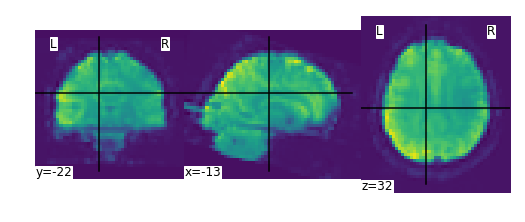

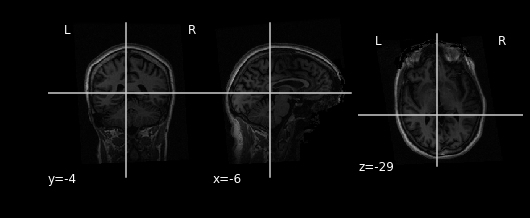

In [55]:
from nilearn.plotting import plot_stat_map, plot_anat, plot_img, show
plot_img(mean_img)
plot_anat(anat_img)

Specifying the experimental paradigm
------------------------------------

We must now provide a description of the experiment, that is, define the
timing of the task and rest periods. This is typically
provided in an events.tsv file.



In [5]:
import pandas as pd
events = pd.read_table('/data/ds000114/task-fingerfootlips_events.tsv')
print(events)

    onset  duration  weight trial_type
0      10      15.0       1     Finger
1      40      15.0       1       Foot
2      70      15.0       1       Lips
3     100      15.0       1     Finger
4     130      15.0       1       Foot
5     160      15.0       1       Lips
6     190      15.0       1     Finger
7     220      15.0       1       Foot
8     250      15.0       1       Lips
9     280      15.0       1     Finger
10    310      15.0       1       Foot
11    340      15.0       1       Lips
12    370      15.0       1     Finger
13    400      15.0       1       Foot
14    430      15.0       1       Lips


Performing the GLM analysis
---------------------------

It is now time to create and estimate a ``FirstLevelModel`` object, that will generate the *design matrix* using the  information provided by the ``events`` object.



In [6]:
from nistats.first_level_model import FirstLevelModel

Parameters of the first-level model

* t_r=?? is the time of repetition of acquisitions
* noise_model='ar1' specifies the noise covariance model: a lag-1 dependence
* standardize=False means that we do not want to rescale the time
series to mean 0, variance 1
* hrf_model='spm' means that we rely on the SPM "canonical hrf"
model (without time or dispersion derivatives)
* drift_model='cosine' means that we model the signal drifts as slow oscillating time functions
* period_cut=160(s) defines the cutoff frequency (its inverse actually).



We need the TR of the functional images, luckily we can extract that information using `nibabel`:

In [7]:
!nib-ls /data/ds000114/derivatives/fmriprep/sub-01/ses-test/func/sub-01_ses-test_task-fingerfootlips_bold_space-mni152nlin2009casym_preproc.nii.gz

/data/ds000114/derivatives/fmriprep/sub-01/ses-test/func/sub-01_ses-test_task-fingerfootlips_bold_space-mni152nlin2009casym_preproc.nii.gz float32 [ 49,  58,  49, 184] 4.00x4.00x4.00x2.50



As we can see the `TR` is 2.5.

In [8]:
fmri_glm = FirstLevelModel(t_r=2.5,
                           noise_model='ar1',
                           standardize=False,
                           hrf_model='spm',
                           drift_model='cosine',
                           period_cut=160)

Usually, we also want to include confounds computed during preprocessing (e.g., motion, global signal, etc.) as regressors of no interest. In our example, these were computed by `fmriprep` and can be found in `derivatives/fmriprep/sub-01/func/`. We can use `pandas` to inspect that file:

In [9]:
confounds = pd.read_csv('/data/ds000114/derivatives/fmriprep/sub-01/ses-test/func/sub-01_ses-test_task-fingerfootlips_bold_confounds.tsv', delimiter='\t')
confounds

,WhiteMatter,GlobalSignal,stdDVARS,non-stdDVARS,vx-wisestdDVARS,FramewiseDisplacement,tCompCor00,tCompCor01,tCompCor02,tCompCor03,...,aCompCor02,aCompCor03,aCompCor04,aCompCor05,X,Y,Z,RotX,RotY,RotZ
0,59.958244,296.705627,NaN,NaN,NaN,NaN,-0.945194,0.178691,-0.008839,0.023860,...,0.001226,-0.070598,0.040292,-0.004502,-6.811590e-03,0.000000,0.000000,0.000000,-0.000000,0.000000
1,-0.992987,-6.791035,10.967166,359.572876,15.125442,0.522051,0.095183,-0.081205,0.043344,-0.067988,...,-0.006754,0.102960,-0.020727,0.005408,-1.198610e-09,-0.035396,0.386632,0.001864,-0.000000,0.000000
2,0.121577,-8.960917,0.965478,31.654449,1.251122,0.053361,0.039534,-0.048124,0.023519,-0.009606,...,-0.006754,0.096988,-0.022278,-0.102161,0.000000e+00,-0.019626,0.383440,0.001176,-0.000000,0.000000
3,-3.207463,-15.836485,0.568300,18.632469,0.933274,0.079333,0.064448,-0.049706,0.013449,-0.031648,...,-0.036826,0.078502,0.003200,-0.112108,0.000000e+00,-0.032375,0.430492,0.001567,-0.000000,0.000000
4,-3.531865,-16.072039,0.412484,13.523833,1.089049,0.030417,0.058324,-0.050976,0.013930,-0.027509,...,-0.024400,0.069612,0.006408,-0.060869,2.562640e-10,-0.032767,0.404579,0.001485,-0.000000,0.000000
5,-4.882755,-15.247290,0.415967,13.638037,0.701060,0.052035,0.058583,-0.047695,0.026299,-0.045036,...,0.000933,0.046052,-0.000392,-0.010349,2.837920e-09,-0.038727,0.424571,0.002006,-0.000000,0.000000
6,-2.747074,-13.935482,0.416321,13.649634,0.962939,0.058154,0.056995,-0.040542,0.023126,-0.034228,...,0.001790,0.044110,-0.008116,0.025086,0.000000e+00,-0.029282,0.403413,0.001455,-0.000000,0.000000
7,-2.122013,-14.288345,0.308540,10.115901,0.495531,0.047950,0.056017,-0.031422,0.028854,-0.048736,...,0.000996,0.031564,-0.012738,0.031255,6.247010e-09,-0.041402,0.410127,0.002038,-0.000000,0.000000
8,-1.969241,-13.966526,0.320861,10.519846,0.513006,0.040255,0.054182,-0.030200,0.025052,-0.031780,...,0.000340,0.013968,0.016111,0.030279,0.000000e+00,-0.032081,0.395135,0.001719,-0.000000,0.000000
9,-2.689761,-13.903376,0.380307,12.468871,0.787305,0.041187,0.053686,-0.031820,0.014250,0.002408,...,-0.000724,0.017050,-0.006971,-0.005033,0.000000e+00,-0.042264,0.409312,0.002055,-0.000000,0.000000


Comparable to other neuroimaging softwards, we have a timepoint x confound dataframe. However, `fmriprep` computes way more confounds than most of you are used to and that require a bit of reading to understand and therefore utilize properly. We therefore and for the sake of simplicity stick to the "classic" ones: `WhiteMatter`, `GlobalSignal`, `FramewiseDisplacement` and the `motion correction parameters` in translation and rotation: 

In [10]:
import numpy as np
confounds_glm = confounds[['WhiteMatter', 'GlobalSignal', 'FramewiseDisplacement', 'X', 'Y', 'Z', 'RotX', 'RotY', 'RotZ']].replace(np.nan, 0)
confounds_glm


,WhiteMatter,GlobalSignal,FramewiseDisplacement,X,Y,Z,RotX,RotY,RotZ
0,59.958244,296.705627,0.000000,-6.811590e-03,0.000000,0.000000,0.000000,-0.000000,0.000000
1,-0.992987,-6.791035,0.522051,-1.198610e-09,-0.035396,0.386632,0.001864,-0.000000,0.000000
2,0.121577,-8.960917,0.053361,0.000000e+00,-0.019626,0.383440,0.001176,-0.000000,0.000000
3,-3.207463,-15.836485,0.079333,0.000000e+00,-0.032375,0.430492,0.001567,-0.000000,0.000000
4,-3.531865,-16.072039,0.030417,2.562640e-10,-0.032767,0.404579,0.001485,-0.000000,0.000000
5,-4.882755,-15.247290,0.052035,2.837920e-09,-0.038727,0.424571,0.002006,-0.000000,0.000000
6,-2.747074,-13.935482,0.058154,0.000000e+00,-0.029282,0.403413,0.001455,-0.000000,0.000000
7,-2.122013,-14.288345,0.047950,6.247010e-09,-0.041402,0.410127,0.002038,-0.000000,0.000000
8,-1.969241,-13.966526,0.040255,0.000000e+00,-0.032081,0.395135,0.001719,-0.000000,0.000000
9,-2.689761,-13.903376,0.041187,0.000000e+00,-0.042264,0.409312,0.002055,-0.000000,0.000000


Now that we have specified the model, we can run it on the fMRI image



In [11]:
fmri_glm = fmri_glm.fit(fmri_img, events, confounds_glm)

/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/nistats/hemodynamic_models.py:268: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  frame_times.max() * (1 + 1. / (n - 1)), n_hr)
/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/nistats/hemodynamic_models.py:55: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  time_stamps = np.linspace(0, time_length, float(time_length) / dt)


One can inspect the design matrix (rows represent time, and
columns contain the predictors).



In [12]:
design_matrix = fmri_glm.design_matrices_[0]

Formally, we have taken the first design matrix, because the model is
implictily meant to for multiple runs.



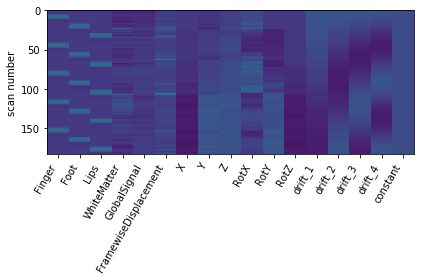

In [54]:
from nistats.reporting import plot_design_matrix
plot_design_matrix(design_matrix)
import matplotlib.pyplot as plt
plt.show()

Save the design matrix image to disk, first creating a directory where you want to write the images:

In [53]:
import os
outdir = 'results'
if not os.path.exists(outdir):
    os.mkdir(outdir)

from os.path import join
plot_design_matrix(design_matrix, output_file=join(outdir, 'design_matrix.png'))

The first column contains the expected reponse profile of regions which are
sensitive to the "Finger" task. Let's plot this first column:



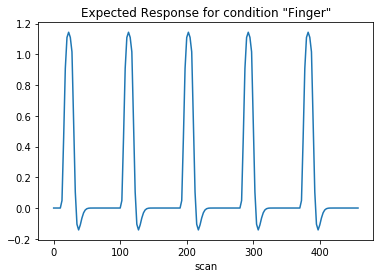

In [50]:
plt.plot(design_matrix['Finger'])
plt.xlabel('scan')
plt.title('Expected Response for condition "Finger"')
plt.show()

Detecting voxels with significant effects
-----------------------------------------

To access the estimated coefficients (Betas of the GLM model), we
created constrast with a single '1' in each of the columns: The role
of the contrast is to select some columns of the model --and
potentially weight them-- to study the associated statistics. So in
a nutshell, a contrast is a weigted combination of the estimated
effects.  Here we can define canonical contrasts that just consider
the two condition in isolation ---let's call them "conditions"---
then a contrast that makes the difference between these conditions.



In [16]:
from numpy import array
conditions = {
    'active - Finger': array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
    'active - Foot':   array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
    'active - Lips':   array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
}

Let's look at it: plot the coefficients of the contrast, indexed by
the names of the columns of the design matrix.



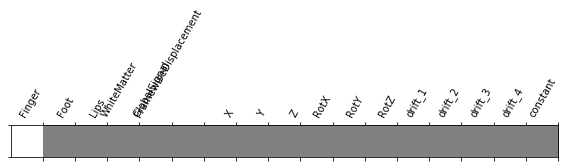

In [49]:
from nistats.reporting import plot_contrast_matrix
plot_contrast_matrix(conditions['active - Finger'], design_matrix=design_matrix)

Below, we compute the estimated effect. It is in BOLD signal unit,
but has no statistical guarantees, because it does not take into
account the associated variance.



In [18]:
eff_map = fmri_glm.compute_contrast(conditions['active - Finger'],
                                    output_type='effect_size')

In order to get statistical significance, we form a t-statistic, and
directly convert is into z-scale. The z-scale means that the values
are scaled to match a standard Gaussian distribution (mean=0,
variance=1), across voxels, if there were now effects in the data.



In [19]:
z_map = fmri_glm.compute_contrast(conditions['active - Finger'],
                                  output_type='z_score')

Plot thresholded z scores map.

We display it on top of the average
functional image of the series (could be the anatomical image of the
subject).  We use arbitrarily a threshold of 3.0 in z-scale. We'll
see later how to use corrected thresholds.  we show to display 3
axial views: display_mode='z', cut_coords=3



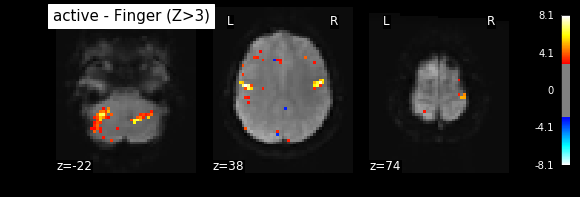

In [48]:
plot_stat_map(z_map, bg_img=mean_img, threshold=3.0,
              display_mode='z', cut_coords=3, black_bg=True,
              title='active - Finger (Z>3)')
plt.show()

Statistical signifiance testing. One should worry about the
statistical validity of the procedure: here we used an arbitrary
threshold of 3.0 but the threshold should provide some guarantees on
the risk of false detections (aka type-1 errors in statistics). One
first suggestion is to control the false positive rate (fpr) at a
certain level, e.g. 0.001: this means that there is.1% chance of
declaring active an inactive voxel.



Uncorrected p<0.001 threshold: 3.090


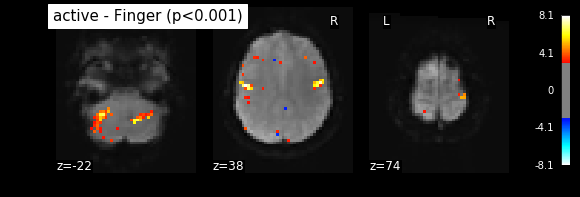

In [47]:
from nistats.thresholding import map_threshold
_, threshold = map_threshold(z_map, level=.001, height_control='fpr')
print('Uncorrected p<0.001 threshold: %.3f' % threshold)
plot_stat_map(z_map, bg_img=mean_img, threshold=threshold,
              display_mode='z', cut_coords=3, black_bg=True,
              title='active - Finger (p<0.001)')
plt.show()

The problem is that with this you expect 0.001 * n_voxels to show up
while they're not active --- tens to hundreds of voxels. A more
conservative solution is to control the family wise errro rate,
i.e. the probability of making ony one false detection, say at
5%. For that we use the so-called Bonferroni correction:



In [22]:
_, threshold = map_threshold(z_map, level=.05, height_control='bonferroni')
print('Bonferroni-corrected, p<0.05 threshold: %.3f' % threshold)
plot_stat_map(z_map, bg_img=mean_img, threshold=threshold,
              display_mode='z', cut_coords=3, black_bg=True,
              title='active - Finger (p<0.05, corrected)')
plt.show()

Bonferroni-corrected, p<0.05 threshold: 4.622


This is quite conservative indeed !  A popular alternative is to
control the false discovery rate, i.e. the expected proportion of
false discoveries among detections. This is called the false
disovery rate.



False Discovery rate = 0.05 threshold: 3.122


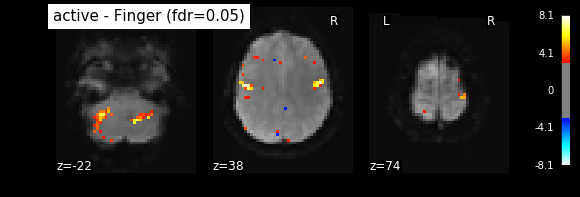

In [46]:
_, threshold = map_threshold(z_map, level=.05, height_control='fdr')
print('False Discovery rate = 0.05 threshold: %.3f' % threshold)
plot_stat_map(z_map, bg_img=mean_img, threshold=threshold,
              display_mode='z', cut_coords=3, black_bg=True,
              title='active - Finger (fdr=0.05)')
plt.show()

Finally people like to discard isolated voxels (aka "small
clusters") from these images. It is possible to generate a
thresholded map with small clusters removed by providing a
cluster_threshold argument. here clusters smaller than 10 voxels
will be discarded.



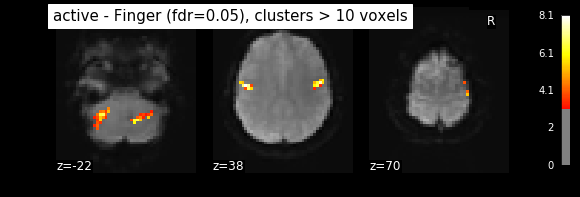

In [45]:
clean_map, threshold = map_threshold(
    z_map, level=.05, height_control='fdr', cluster_threshold=10)
plot_stat_map(clean_map, bg_img=mean_img, threshold=threshold,
              display_mode='z', cut_coords=3, black_bg=True,
              title='active - Finger (fdr=0.05), clusters > 10 voxels')
plt.show()

We can save the effect and zscore maps to the disk



In [25]:
z_map.to_filename(join(outdir, 'active_finger_z_map.nii.gz'))
eff_map.to_filename(join(outdir, 'active_finger_eff_map.nii.gz'))

Report the found positions in a table



In [26]:
from nistats.reporting import get_clusters_table
table = get_clusters_table(z_map, stat_threshold=threshold,
                           cluster_threshold=20)
print(table)

  Cluster ID     X     Y     Z  Peak Stat Cluster Size (mm3)
0          1  44.0 -12.0  58.0   7.004679               2048
1         1a  40.0 -16.0  50.0   6.056288                   
2         1b  40.0 -24.0  70.0   5.628335                   
3          2 -32.0 -52.0 -22.0   5.958555               1408
4         2a -24.0 -48.0 -22.0   5.695553                   


This table can be saved for future use:



In [27]:
table.to_csv(join(outdir, 'table.csv'))

Or use [atlasreader](https://github.com/miykael/atlasreader) to get even more information and informative figures:

In [28]:
from atlasreader import create_output
create_output(join(outdir, 'active_finger_z_map.nii.gz'), cluster_extent=5)

/opt/miniconda-latest/envs/neuro/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


The Python package you are importing, AtlasReader, is licensed under the
BSD-3 license; however, the atlases it uses are separately licensed under more
restrictive frameworks.
By using AtlasReader, you agree to abide by the license terms of the
individual atlases. Information on these terms can be found online at:
https://github.com/miykael/atlasreader/tree/master/atlasreader/data



/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/atlasreader/atlasreader.py:826: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.values' or 'np.asarray(..)' instead.
  coords = clust_frame[['peak_x', 'peak_y', 'peak_z']].get_values()
/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


Let's have a look at the csv file containing relevant information about the peak of each cluster. This table contains the cluster association and location of each peak, its signal value at this location, the cluster extent (in mm, not in number of voxels), as well as the membership of each peak, given a particular atlas.

In [29]:
peak_info = pd.read_csv('results/active_finger_z_map_peaks.csv')
peak_info

,cluster_id,peak_x,peak_y,peak_z,peak_value,volume_mm,aal,desikan_killiany,harvard_oxford
0,1,44,-12,58,7.00468,15872,Precentral_R,ctx-rh-precentral,63% Right_Precentral_Gyrus; 13% Right_Postcent...
1,2,-32,-52,-22,5.95855,7936,Fusiform_L,Unknown,26% Left_Temporal_Occipital_Fusiform_Cortex
2,3,44,-44,54,4.31018,5184,Parietal_Inf_R,Unknown,30% Right_Supramarginal_Gyrus_posterior_divisi...
3,4,24,-52,-18,4.42190,4544,Cerebelum_6_R,Unknown,14% Right_Temporal_Occipital_Fusiform_Cortex
4,5,68,-16,22,3.33671,2240,Postcentral_R,Unknown,46% Right_Postcentral_Gyrus; 8% Right_Supramar...
5,6,36,-72,38,3.22415,1920,Occipital_Mid_R,ctx-rh-inferiorparietal,58% Right_Lateral_Occipital_Cortex_superior_di...
6,7,60,8,6,3.58387,1472,Rolandic_Oper_R,ctx-rh-precentral,46% Right_Precentral_Gyrus; 18% Right_Inferior...
7,8,64,-44,14,4.29185,1472,Temporal_Sup_R,Unknown,35% Right_Supramarginal_Gyrus_posterior_divisi...
8,9,64,4,30,3.51253,1344,Precentral_R,Unknown,28% Right_Precentral_Gyrus
9,10,40,44,30,4.02404,1216,Frontal_Mid_2_R,Unknown,80% Right_Frontal_Pole; 5% Right_Middle_Fronta...


And the clusters:

In [30]:
cluster_info = pd.read_csv('results/active_finger_z_map_clusters.csv')
cluster_info

,cluster_id,peak_x,peak_y,peak_z,cluster_mean,volume_mm,aal,desikan_killiany,harvard_oxford
0,1,44,-12,58,3.09618,15872,38.31% Precentral_R; 19.76% Postcentral_R; 12....,42.74% Unknown; 22.58% Right-Cerebral-White-Ma...,41.13% Right_Precentral_Gyrus; 27.02% Right_Po...
1,2,-32,-52,-22,2.95948,7936,36.29% Fusiform_L; 23.39% Cerebelum_6_L; 20.97...,44.35% Left-Cerebellum-Cortex; 36.29% Unknown;...,37.90% Left_Temporal_Occipital_Fusiform_Cortex...
2,3,44,-44,54,2.69376,5184,43.21% Parietal_Inf_R; 40.74% Parietal_Sup_R; ...,41.98% Unknown; 33.33% ctx-rh-superiorparietal...,53.09% Right_Superior_Parietal_Lobule; 19.75% ...
3,4,24,-52,-18,2.62451,4544,42.25% Fusiform_R; 32.39% Cerebelum_6_R; 9.86%...,30.99% Right-Cerebellum-Cortex; 29.58% Unknown...,45.07% Right_Occipital_Fusiform_Gyrus; 32.39% ...
4,5,68,-16,22,2.42240,2240,62.86% SupraMarginal_R; 17.14% Postcentral_R; ...,42.86% ctx-rh-supramarginal; 42.86% Unknown; 8...,40.00% Right_Parietal_Operculum_Cortex; 31.43%...
5,6,36,-72,38,2.44570,1920,40.00% Occipital_Mid_R; 26.67% Angular_R; 20.0...,43.33% Right-Cerebral-White-Matter; 33.33% ctx...,100.00% Right_Lateral_Occipital_Cortex_superio...
6,7,60,8,6,2.52718,1472,52.17% Rolandic_Oper_R; 43.48% Frontal_Inf_Oper_R,34.78% ctx-rh-precentral; 30.43% Unknown; 17.3...,39.13% Right_Precentral_Gyrus; 39.13% Right_In...
7,8,64,-44,14,2.73240,1472,69.57% Temporal_Sup_R; 26.09% Temporal_Mid_R,60.87% Unknown; 30.43% ctx-rh-superiortemporal,47.83% Right_Supramarginal_Gyrus_posterior_div...
8,9,64,4,30,2.60643,1344,57.14% Precentral_R; 42.86% Frontal_Inf_Oper_R,52.38% ctx-rh-precentral; 42.86% Unknown,85.71% Right_Precentral_Gyrus; 9.52% Right_Inf...
9,10,40,44,30,2.53231,1216,100.00% Frontal_Mid_2_R,52.63% ctx-rh-rostralmiddlefrontal; 26.32% Rig...,94.74% Right_Frontal_Pole; 5.26% Right_Middle_...


For each cluster, we also get a corresponding visualization, saved as `.png`:

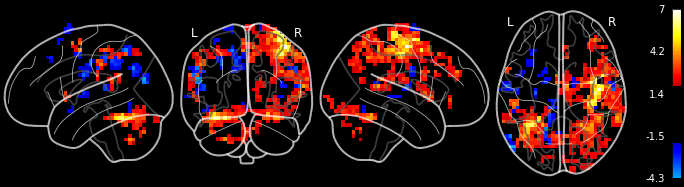

In [31]:
from IPython.display import Image
Image("results/active_finger_z_map.png")

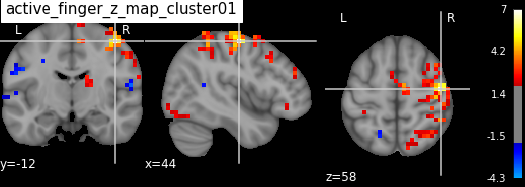

In [32]:
Image("results/active_finger_z_map_cluster01.png")

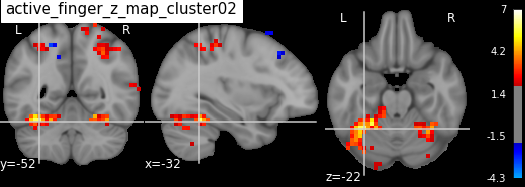

In [33]:
Image("results/active_finger_z_map_cluster02.png")

### Performing an F-test

"active vs rest" is a typical t test: condition versus
baseline. Another popular type of test is an F test in which one
seeks whether a certain combination of conditions (possibly two-,
three- or higher-dimensional) explains a significant proportion of
the signal.  Here one might for instance test which voxels are well
explained by combination of the active and rest condition.



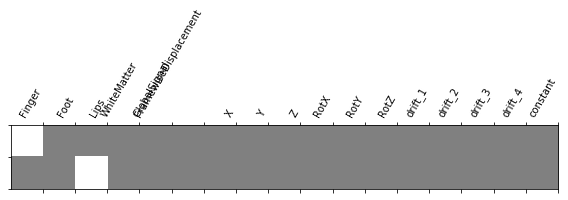

In [40]:
import numpy as np
effects_of_interest = np.vstack((conditions['active - Finger'], conditions['active - Lips']))
plot_contrast_matrix(effects_of_interest, design_matrix)
plt.show()

Specify the contrast and compute the correspoding map. Actually, the
contrast specification is done exactly the same way as for t
contrasts.



In [44]:
z_map = fmri_glm.compute_contrast(effects_of_interest,
                                  output_type='z_score')

Note that the statistic has been converted to a z-variable, which
makes it easier to represent it.



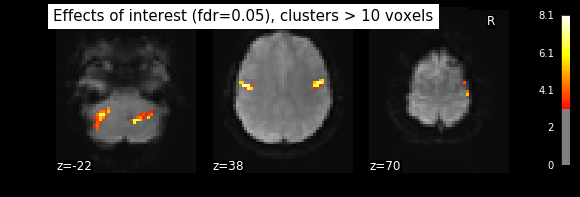

In [43]:
clean_map, threshold = map_threshold(
    z_map, level=.05, height_control='fdr', cluster_threshold=10)
plot_stat_map(clean_map, bg_img=mean_img, threshold=threshold,
              display_mode='z', cut_coords=3, black_bg=True,
              title='Effects of interest (fdr=0.05), clusters > 10 voxels')
plt.show()